In [1]:
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
from helper_functions import linear_fit_field, RBF, MSE

# Non-linear Vectorfield approximation

## Load data into train and test 

In [2]:
x0 = np.genfromtxt('data/nonlinear_vectorfield_data_x0.txt')
x1 = np.genfromtxt('data/nonlinear_vectorfield_data_x1.txt')
x0_train, x0_test, x1_train, x1_test = train_test_split(x0, x1, test_size=0.2, random_state = 42, shuffle=False)
dt = .01
v = (x1 - x0)/dt
v_train = (x1_train - x0_train)/dt
v_test = (x1_test - x0_test)/dt

### Original datasets

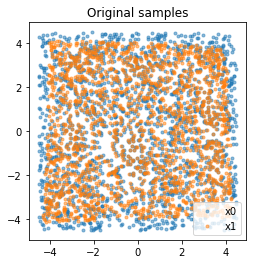

In [3]:
plt.scatter(x0[:,0], x0[:,1],marker='.', label='x0',alpha=0.5)
plt.scatter(x1[:,0], x1[:,1],marker='.', label='x1', alpha=0.5)
plt.gca().set_aspect('equal')
plt.title("Original samples")
plt.legend()

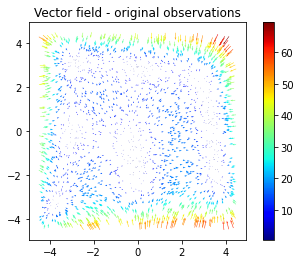

In [4]:
plt.title('Vector field - original observations')
plt.quiver(x0[:,0], x0[:,1], v[:,0], v[:,1], np.linalg.norm(v,axis=1),cmap='jet')
plt.gca().set_aspect('equal')
plt.colorbar()

## Linear fit

In [5]:
A = linear_fit_field(x0, v)
vhat = x0@A
x1_l = x0 + vhat*dt

In [6]:
MSE(x1,x1_l)

0.037270081174962

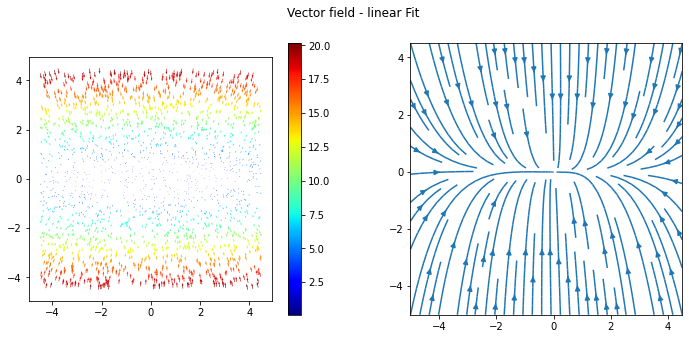

In [7]:
X, Y = np.meshgrid(np.arange(-5,5, .5), np.arange(-5,5,.5))
XY = np.array([X.flatten(), Y.flatten()]).T
UV = XY@A.T
U, V = [W.reshape(X.shape) for W in UV.T]

plt.figure(figsize=(12,5))
plt.suptitle("Vector field - linear Fit")
plt.subplot(121)
plt.quiver(x0[:,0], x0[:,1], vhat[:,0], vhat[:,1], np.linalg.norm(vhat,axis=1),cmap='jet')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(122)
plt.streamplot(X, Y, U, V)
plt.gca().set_aspect('equal')

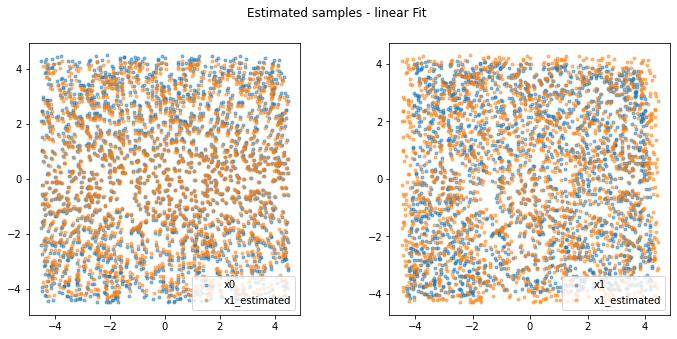

In [8]:
plt.figure(figsize=(12,5))
plt.suptitle("Estimated samples - linear Fit")
plt.subplot(121)
plt.scatter(x0[:,0], x0[:,1],marker='.', label='x0',alpha=0.5)
plt.scatter(x1_l[:,0], x1_l[:,1],marker='.', label='x1_estimated', alpha=0.5)
plt.gca().set_aspect('equal')
plt.legend()
plt.subplot(122)
plt.scatter(x1[:,0], x1[:,1],marker='.', label='x1',alpha=0.5)
plt.scatter(x1_l[:,0], x1_l[:,1],marker='.', label='x1_estimated', alpha=0.5)
plt.gca().set_aspect('equal')
plt.legend()

## Non-linear fit

### Identifying suitable hypermarameters (scale and number of RBFs)

Carried out on a 20% train-test split, with scoring the the model for each set of hyperparameters against the test set to avoid overfit

In [9]:
# Rigorous estimate based on score
params = {'eps':[0.5,1,5, 10], 'L':[20, 50, 100, 500, 1000], 'rcond':[None, 0.005]}
rbf0 = RBF(0, 0)
rbf_cv = GridSearchCV(rbf0, params, scoring=lambda mod, _, __: 1./MSE(v_test, mod.predict(x0_test)))
rbf_cv.fit(x0_train, v_train)
display(pd.DataFrame(rbf_cv.cv_results_)[['params',
                                          'mean_test_score',
                                          'mean_score_time']].sort_values('mean_test_score',ascending=False).head())

,params,mean_test_score,mean_score_time
36,"{'L': 1000, 'eps': 5, 'rcond': None}",9.105733e+07,0.068051
28,"{'L': 500, 'eps': 5, 'rcond': None}",7.627410e+07,0.032359
20,"{'L': 100, 'eps': 5, 'rcond': None}",2.442332e+06,0.007014
34,"{'L': 1000, 'eps': 1, 'rcond': None}",1.002597e+05,0.071935
38,"{'L': 1000, 'eps': 10, 'rcond': None}",3.676463e+04,0.070535


### Using an efficient model

In [10]:
# Judgement based
rbf = RBF(100, 5)
rbf.fit(x0_train, v_train)
vhat = rbf.predict(x0)
MSE(v, vhat)

2.561929844205753e-07

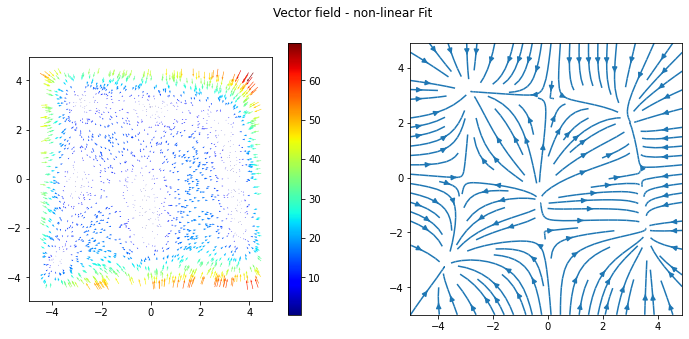

In [11]:
X, Y = np.meshgrid(np.arange(-5,5, .1), np.arange(-5,5,.1))
XY = np.array([X.flatten(), Y.flatten()]).T
UV = rbf.predict(XY)
U, V = [W.reshape(X.shape) for W in UV.T]

plt.figure(figsize=(12,5))
plt.suptitle("Vector field - non-linear Fit")
plt.subplot(121)
plt.quiver(x0[:,0], x0[:,1], vhat[:,0], vhat[:,1], np.linalg.norm(vhat,axis=1),cmap='jet')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(122)
plt.streamplot(X, Y, U, V)
plt.gca().set_aspect('equal')

### Integrating further in time

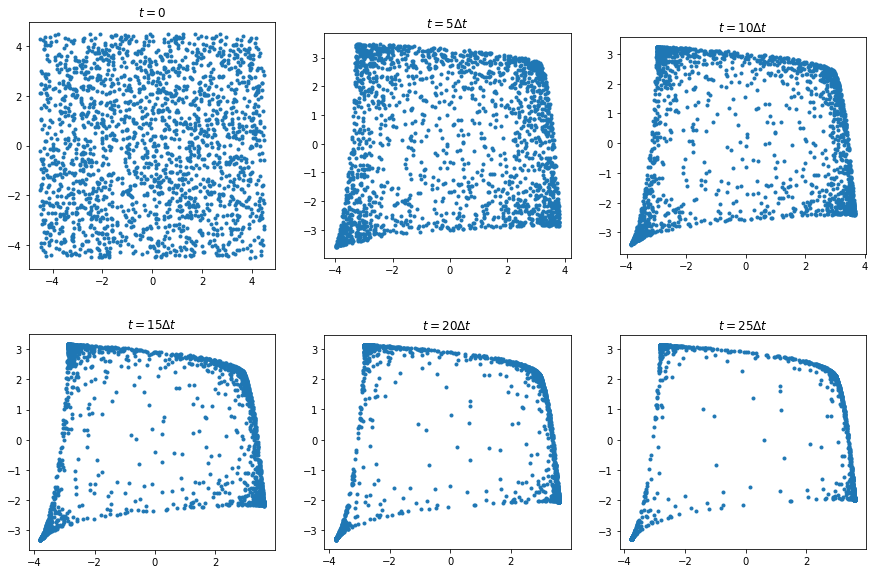

In [12]:
x = x0.copy()
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.scatter(x[:,0], x[:,1], marker='.', label=r'$x_0$')
plt.title(r'$t=0$')
plt.gca().set_aspect('equal')

for i in range(1,26):
    vhat = rbf.predict(x)
    x += vhat*dt
    if(not i%5):
        ii = i//5
        plt.subplot(231+ii)
        plt.scatter(x[:,0], x[:,1], marker='.', label=rf'$x_{{{i}}}$')
        plt.title(rf'$t={5*ii}\Delta t$')
        plt.gca().set_aspect('equal')
